# **Classification**( essentials )

## **MNIST dataset**
Considerado el "Hello World" en ML es un conjunto de 70.000 pequeñas imágenes(28x28) de dígitos escritas a mano por
estudiantes de secundaria y empleados de US Census Bureau

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
import joblib

# guardar el objeto mnist completo que es  sklearn.utils.Bunch (similar a un diccioanrio )
joblib.dump(mnist, "resources/mnist_784.z",compress=3)



['resources/mnist_784.z']

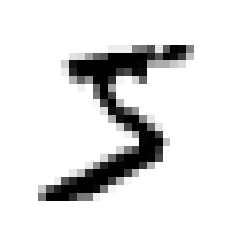

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

X, y = mnist["data"], mnist["target"]
X.shape

some_digit = np.array(X.loc[0,:])
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


In [5]:
y[0]


'5'

In [6]:
# Note that the label is a string. Most ML algorithms expect numbers
y = y.astype(np.uint8)

## Create test-train set

In [7]:
# podemos hacer esto pq los numeros estan distribuidos
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000],y[60000:]

## **Training a Binary Classifier**

In [8]:
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

### Implementing CROSS-VALIDATION
Ocasionalmente, necesitará más control sobre el proceso de validación
cruzada que el que Scikit-Learn proporciona. En estos casos, puede
implementar la validación cruzada usted mismo. El siguiente código
hace aproximadamente lo mismo que la función cross_val_score() de
Scikit-Learn, e imprime el mismo resultado

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = np.array(X_train)[train_index]
    y_train_folds = np.array(y_train_5)[train_index]
    X_test_fold = np.array(X_train)[test_index]
    y_test_fold = np.array(y_train_5)[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.9669
0.91625
0.96785


___
Antes de continuar vamos a implementar el **clasificador nulo** que siempre predice cero

In [10]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [11]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

## **Precision/Recall Trade-off(Intercambio)**

In [12]:
# devolver puntuaciones de decisión en lugar de predicciones
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")


With these scores, use the precision_recall_curve() *(only for binary classification)* function to
compute precision and recall for all possible **thresholds**. 
 
**Thresholds** es el umbral de decision que utiliza SDGClassifier para realizar las predicciones

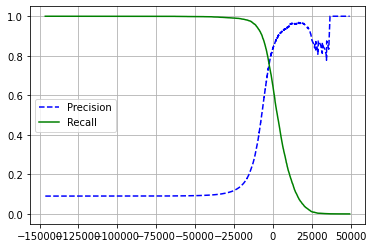

In [20]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.grid()

## **Multilabel Classification**

In [42]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [45]:
# The digit 5 is indeed not large(False) and odd (True)
knn_clf.predict([some_digit])

c:\Users\Manue!_PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [47]:
# usar la puntuacion F1 para medir al classifier

from sklearn.metrics import f1_score

y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3 )

f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

**average= "macro"** supone que todas las etiquetas tienen la misma importancia,
 opción sencilla es
dar a cada etiqueta un peso igual a su soporte (es decir, el número de
instancias con esa etiqueta objetivo). Para ello, basta con establecer
**average="weighted"** en el código anterio